In [1]:
# squidpy ligand-rec cellphonedb analysis on esoatlas

In [1]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import pickle as pkl

/opt/conda/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [2]:
mkdir results

In [3]:
import sys
sys.path.append('..')
from util import load_original_data

In [4]:
# the atlas adata
q = load_original_data()

# load the finegrained labels obs
qobs = pd.read_csv('../EsoAtlas_july182022_obs_w_fine_grain_celltypes.csv', index_col=0)

# getting into the right order
qobs = qobs.loc[q.obs.index,:]

# copying it over
q.obs = qobs

# drop cells without a fine grained label
qobs2 = q.obs.dropna(subset=['Fine_Grained_Label'])

q = q[qobs2.index]

In [5]:
q

View of AnnData object with n_obs × n_vars = 102887 × 35606
    obs: 'samplename', 'n_genes', 'n_molecules', 'doublet_score', 'percent_mito', 'leiden', 'louvain', 'diagnosis', 'phase', 'sample_diagnosis', 'patient', 'treatment', 'procedure', 'hcl_refined', 'hcl_celltype', 'hcl_score', 'CLid', 'CL_name', 'nobatch_leiden', 'nobatch_louvain', 'cnv_avg', 'has_cnv', 'allcells_leiden', 'allcells_nobatch_leiden', 'ct_leiden', 'ct_nobatch_leiden', 'celltype_split', 'Coarse_Grained_Label', 'Fine_Grained_Label'
    var: 'gene_ids', 'feature_types', 'genome', 'is_mito', 'is_ribo', 'old_genename'
    uns: 'celltype_split_colors', 'diagnosis_colors', 'leiden', 'leiden_colors', 'leiden_sizes', 'log_X', 'log_raw.X', 'louvain', 'neighbors', 'nobatch', 'nobatch_leiden_colors', 'nobatch_leiden_sizes', 'nobatch_rank_genes_groups', 'nobatch_rank_genes_groups_filtered', 'nobatch_rank_genes_groups_unfiltered', 'paga', 'pca', 'rank_genes_groups', 'rank_genes_groups_filtered', 'rank_genes_groups_unfiltered', 

In [6]:
qdx = q[q.obs.diagnosis == 'M'].copy()
#del q, qobs, qobs2
sc.pp.normalize_total(qdx,target_sum=10000)
# they do this in several tutorials..
qdx.raw = qdx.copy()
qdx.obs['Fine_Grained_Label'] = qdx.obs['Fine_Grained_Label'].astype('category')
qdx.obs['Coarse_Grained_Label'] = qdx.obs['Coarse_Grained_Label'].astype('category')
qdx.obs['leiden'] = qdx.obs['leiden'].astype('category')

In [7]:
ci = "Plasma cells"
gi = "CXCR4"
X = (qdx[qdx.obs.Fine_Grained_Label == ci, gi].X > 3)
X.nnz / X.shape[0]

0.0070921985815602835

In [8]:
ci = 'Capillary endothelial cells'
gi = 'CD36'
X = (qdx[qdx.obs.Fine_Grained_Label == ci, gi].X > 3)
X.nnz / X.shape[0]

0.21951219512195122

In [9]:
#NS
ci = 'Fibroblasts, CAF'
gi = 'POSTN'
X = (qdx[qdx.obs.Fine_Grained_Label == ci, gi].X > 3)
X.nnz / X.shape[0]

0.8661971830985915

In [10]:
qdx[qdx.obs.Fine_Grained_Label == ci, gi].X.mean()

67.33069

In [11]:
#T
ci = 'Fibroblasts, CAF'
gi = 'POSTN'
X = (qdx[qdx.obs.Fine_Grained_Label == ci, gi].X > 3)
X.nnz / X.shape[0]

0.8661971830985915

In [12]:
qdx[qdx.obs.Fine_Grained_Label == ci, gi].X.mean()

67.33069

In [13]:
121.56 / 51.91

2.3417453284530922

In [14]:
#M
ci = 'Fibroblasts, CAF'
gi = 'POSTN'
X = (qdx[qdx.obs.Fine_Grained_Label == ci, gi].X > 3)
X.nnz / X.shape[0]

0.8661971830985915

In [15]:
qdx[qdx.obs.Fine_Grained_Label == ci, gi].X.mean()

67.33069

In [16]:
64.57 / 51.91

1.2438836447697939

In [17]:
cellnames = list(set(qdx.obs.Coarse_Grained_Label))
reslist = {}
for ci in cellnames: #= "CD8 T cells"
    #ci = 'Proliferating T cells' # "CD8 T cells" #
    X = (qdx[qdx.obs.Coarse_Grained_Label == ci].X > 3)
    rows, cols = X.nonzero()
    numcells = float(X.shape[0])
    gene_col_cnt = np.bincount(np.array(cols))
    if len(gene_col_cnt) < 35606:
        print(ci)
        numMissing = 35606 - len(gene_col_cnt)
        gene_col_cnt = np.pad(gene_col_cnt, (0, numMissing), 'constant', constant_values=(0, 0))
    geneFrac = gene_col_cnt / numcells
    reslist[ci] = geneFrac
pd.DataFrame(reslist, index=qdx.var.index).to_csv('ligrec_results/gene_fracs_T_coarse_grained.csv')

Neutrophils


In [18]:
cellnames = list(set(qdx.obs.Fine_Grained_Label))
reslist = {}
for ci in cellnames: #= "CD8 T cells"
    #ci = 'Proliferating T cells' # "CD8 T cells" #
    X = (qdx[qdx.obs.Fine_Grained_Label == ci].X > 3)
    rows, cols = X.nonzero()
    numcells = float(X.shape[0])
    gene_col_cnt = np.bincount(np.array(cols))
    if len(gene_col_cnt) < 35606:
        print(ci)
        numMissing = 35606 - len(gene_col_cnt)
        gene_col_cnt = np.pad(gene_col_cnt, (0, numMissing), 'constant', constant_values=(0, 0))
    geneFrac = gene_col_cnt / numcells
    reslist[ci] = geneFrac
pd.DataFrame(reslist, index=qdx.var.index).to_csv('ligrec_results/gene_fracs_T_fine_grained.csv')

Pericytes
Squamous epithelium intermediate
Proliferating T cells
Squamous epithelium upper
Neutrophils
Plasmacytoid dendritic cells
Memory B cells
Dendritic cells


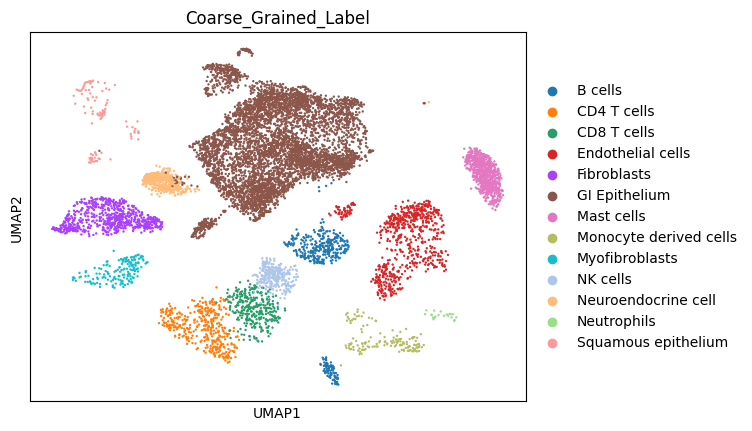

In [19]:
sc.pl.umap(qdx, color='Coarse_Grained_Label')

In [20]:
res = sq.gr.ligrec(
    qdx,
    n_perms=1000,
    threshold=0.00001,
    cluster_key="Coarse_Grained_Label",
    copy=True,
    use_raw=False,
    interactions_params={"resources": "CellPhoneDB"},
    #interactions=lrs,
    jobs=4
    #transmitter_params={"categories": "ligand"},
    #receiver_params={"categories": "receptor"},
)


  0%|          | 0/1000 [00:00<?, ?permutation/s]

In [21]:
p = pkl.dumps(res)
fout = open('results/coarse_ligrec.pkl', 'wb')
fout.write(p)
fout.close()

In [22]:
diagstr = 'T'
qsub = q[q.obs.diagnosis == diagstr].copy()

In [23]:
del q, qobs, qobs2

In [24]:
from scipy import sparse

In [25]:
qsub

AnnData object with n_obs × n_vars = 32899 × 35606
    obs: 'samplename', 'n_genes', 'n_molecules', 'doublet_score', 'percent_mito', 'leiden', 'louvain', 'diagnosis', 'phase', 'sample_diagnosis', 'patient', 'treatment', 'procedure', 'hcl_refined', 'hcl_celltype', 'hcl_score', 'CLid', 'CL_name', 'nobatch_leiden', 'nobatch_louvain', 'cnv_avg', 'has_cnv', 'allcells_leiden', 'allcells_nobatch_leiden', 'ct_leiden', 'ct_nobatch_leiden', 'celltype_split', 'Coarse_Grained_Label', 'Fine_Grained_Label'
    var: 'gene_ids', 'feature_types', 'genome', 'is_mito', 'is_ribo', 'old_genename'
    uns: 'celltype_split_colors', 'diagnosis_colors', 'leiden', 'leiden_colors', 'leiden_sizes', 'log_X', 'log_raw.X', 'louvain', 'neighbors', 'nobatch', 'nobatch_leiden_colors', 'nobatch_leiden_sizes', 'nobatch_rank_genes_groups', 'nobatch_rank_genes_groups_filtered', 'nobatch_rank_genes_groups_unfiltered', 'paga', 'pca', 'rank_genes_groups', 'rank_genes_groups_filtered', 'rank_genes_groups_unfiltered', 'umap'
  

In [ ]:
# first normalize the counts
sc.pp.normalize_total(qsub, target_sum=10000)

# they do this in several tutorials..
qsub.raw = qsub.copy()
qsub.X = sparse.csr_matrix(qsub.X)
qsub.obs['Fine_Grained_Label'] = qsub.obs['Fine_Grained_Label'].astype('category')
qsub.obs['Coarse_Grained_Label'] = qsub.obs['Coarse_Grained_Label'].astype('category')
qsub.obs['leiden'] = qsub.obs['leiden'].astype('category')

res_coarse = sq.gr.ligrec(
    qsub,
    n_perms=1000,
    threshold=0.00001,
    cluster_key="Coarse_Grained_Label",
    copy=True,
    use_raw=False,
    interactions_params={"resources": "CellPhoneDB"},
    #interactions=lrs,
    jobs=4
    #transmitter_params={"categories": "ligand"},
    #receiver_params={"categories": "receptor"},
)

res_fine = sq.gr.ligrec(
    qsub,
    n_perms=1000,
    threshold=0.00001,
    cluster_key="Fine_Grained_Label",
    copy=True,
    use_raw=False,
    interactions_params={"resources": "CellPhoneDB"},
    #interactions=lrs,
    jobs=4
    #transmitter_params={"categories": "ligand"},
    #receiver_params={"categories": "receptor"},
)


p_coarse = pkl.dumps(res_coarse)
fout = open('results/'+diagstr+'coarse_ligrec.pkl', 'wb')
fout.write(p_coarse)
fout.close()

p_fine = pkl.dumps(res_fine)
fout = open('results/'+diagstr+'fine_ligrec.pkl', 'wb')
fout.write(p_fine)
fout.close()


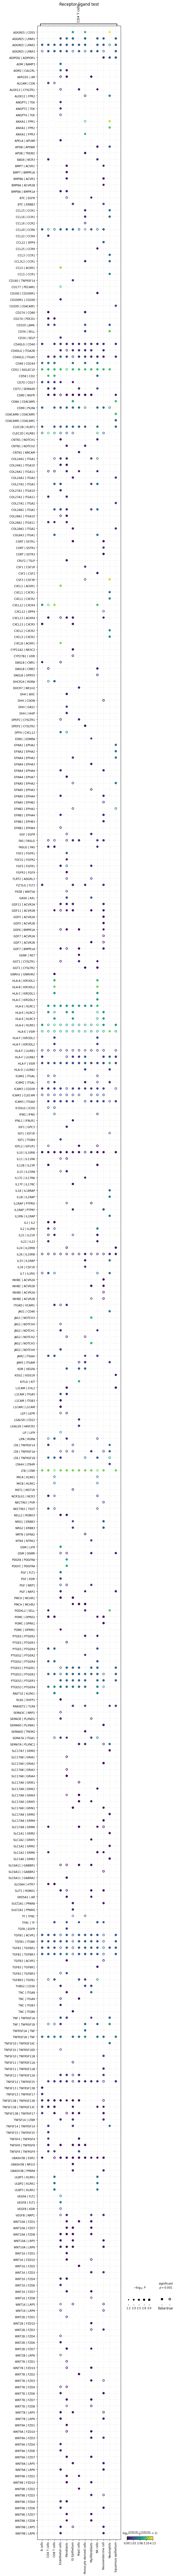

In [28]:
sq.pl.ligrec(res, source_groups="CD4 T cells", alpha=0.001, pvalue_threshold=0.001, remove_nonsig_interactions=True)

In [185]:
import pickle as pkl
import numpy as np

In [186]:
fin = open('ligrec_results/m_fine_ligrec.pkl', 'rb')
res_m = pkl.load(fin)

fin = open('ligrec_results/t_fine_ligrec.pkl', 'rb')
res_t = pkl.load(fin)

In [187]:
pm_df = res_m['pvalues']

In [188]:
cit = 'Foveolar cells'
cjt = 'Capillary endothelial cells'

In [189]:
one_row = pm_df.iloc[31,:]
one_row[cit][cjt]

0.0163

In [190]:
cellnames = one_row['CD4 T cells'].index.tolist()
cellnames

['Arterial endothelial cells',
 'CD4 T cells',
 'CD8 T cells',
 'Capillary endothelial cells',
 'Chief cells',
 'Dendritic cells',
 'Dysplasia-carcinoma',
 'Fibroblasts, CAF',
 'Fibroblasts, NAF',
 'Foveolar cells',
 'Gastric mucous secreting cells',
 'Gastro-intestinal metaplasia',
 'Goblet cells',
 'Lymphatic endothelial cells',
 'Macrophages',
 'Mast cells',
 'Memory B cells',
 'Monocytes',
 'Myofibroblasts-1',
 'Myofibroblasts-2',
 'NK cells',
 'Naive B cells',
 'Neuroendocrine cells',
 'Neutrophils',
 'Pericytes',
 'Plasma cells',
 'Plasmacytoid dendritic cells',
 'Proliferating T cells',
 'Secretory cells',
 'Squamous epithelium basal',
 'Squamous epithelium intermediate',
 'Squamous epithelium upper',
 'Stressed Dying T cells',
 'T regs',
 'Venous endothelial cells']

In [191]:
len(cellnames) * len(cellnames)

1225

In [192]:
def unravel(one_row, cit, cjt):  # cit: ci target
    cellpairs = []
    values = []
    idx = None
    cnt = 0
    for ci in cellnames:
        for cj in cellnames:
            cellpairs.append(ci+'_'+cj)
            values.append(one_row[ci][cj])
            if ci == cit and cj == cjt:
                idx = cnt 
            cnt += 1
    values = np.array(values)
    return( (cellpairs, values, idx) )

In [193]:
res0 = []
# for each row in the tables that is signifcant for cit-cjt
# get the number of significant LR pairs
for row_i in range(0, pm_df.shape[0]):
    if row_i % 200 == 0:
        print(row_i)
    one_row = pm_df.iloc[row_i,:]
    if one_row[cit][cjt] < 0.01:
        (cps, vals, idx) = unravel(one_row, cit, cjt)
        res0.append(sum(vals < 0.01))# < 5:  # this includes results of cit-cjt
    
        #    res0.append(row_i)


0
200
400
600
800
1000
1200
1400


In [194]:
res0.sort()

In [195]:
res0

[5,
 10,
 12,
 12,
 13,
 17,
 18,
 19,
 20,
 20,
 23,
 24,
 24,
 24,
 24,
 25,
 25,
 26,
 27,
 27,
 27,
 30,
 30,
 30,
 32,
 33,
 35,
 35,
 36,
 36,
 36,
 38,
 39,
 40,
 42,
 42,
 42,
 43,
 46,
 46,
 48,
 48,
 48,
 51,
 53,
 54,
 54,
 55,
 55,
 57,
 58,
 58,
 60,
 62,
 63,
 64,
 64,
 64,
 65,
 65,
 69,
 70,
 71,
 71,
 72,
 72,
 73,
 73,
 74,
 76,
 77,
 80,
 80,
 82,
 82,
 83,
 84,
 84,
 85,
 86,
 87,
 87,
 88,
 88,
 88,
 89,
 91,
 92,
 92,
 94,
 94,
 94,
 96,
 96,
 97,
 97,
 98,
 98,
 98,
 99,
 100,
 100,
 100,
 101,
 101,
 102,
 103,
 104,
 105,
 107,
 108,
 109,
 109,
 109,
 109,
 109,
 110,
 110,
 112,
 112,
 113,
 115,
 115,
 115,
 115,
 120,
 121,
 122,
 126,
 126,
 126,
 127,
 128,
 130,
 130,
 131,
 133,
 134,
 135,
 135,
 137,
 139,
 139,
 140,
 142,
 142,
 143,
 143,
 144,
 144,
 145,
 146,
 146,
 147,
 147,
 148,
 148,
 148,
 150,
 150,
 151,
 154,
 155,
 155,
 155,
 157,
 158,
 162,
 162,
 163,
 163,
 164,
 169,
 171,
 171,
 172,
 174,
 175,
 175,
 178,
 178,
 179,
 180,
 18

In [196]:
wm_df = res_m['means']
wt_df = res_t['means']
pm_df = res_m['pvalues']
pt_df = res_t['pvalues']

In [197]:
pm_df.shape

(1598, 1225)

In [198]:
pt_df.shape

(1637, 1296)

In [199]:
sum(np.array(pm_df[cit, cjt].tolist()) < 0.0001)

177

In [200]:
sum(np.array(pt_df[cit, cjt].tolist()) < 0.0001)

349

In [201]:
idx = np.array(pm_df[cit, cjt].tolist()) < 0.0001
jdx = np.array(pt_df[cit, cjt].tolist()) < 0.0001
idx2 = np.array(pm_df[cjt, cit].tolist()) < 0.0001
jdx2 = np.array(pt_df[cjt, cit].tolist()) < 0.0001

In [202]:
sum( [ (x or y) for (x,y) in zip(idx, idx2) ] )

260

In [203]:
#take pairs that are either C_i -> C_j or C_j -> C_i
idx = [ (x or y) for (x,y) in zip(idx, idx2) ]
jdx = [ (x or y) for (x,y) in zip(jdx, jdx2) ]

In [204]:
np.array(wm_df[cit, cjt])[idx].mean()

0.8214389272627318

In [205]:
np.array(wt_df[cit, cjt])[jdx].mean()

0.5507216321171141

In [206]:
# the metaplasia samples show a higher mean L-R expression for significant linkages

In [207]:
np.array(wm_df[cjt, cit])[idx]

array([4.81390194e-01, 4.61085235e-01, 8.74128968e-01, 0.00000000e+00,
       7.95426728e-01, 0.00000000e+00, 5.45695611e-01, 5.25390652e-01,
       8.59732145e-01, 4.34675207e-01, 7.48711742e-01, 4.64211380e-01,
       4.43906421e-01, 8.56950154e-01, 7.78247914e-01, 0.00000000e+00,
       1.24553744e-01, 2.95005800e-01, 6.65451992e+00, 1.29320712e+00,
       1.08298304e+00, 1.18616144e+00, 1.20962561e+00, 1.14708035e+00,
       1.08118994e+00, 2.17854224e+00, 1.47227798e-01, 6.92586737e-01,
       8.12875771e-01, 8.07387246e-01, 8.02544830e-01, 0.00000000e+00,
       0.00000000e+00, 3.88191040e-01, 0.00000000e+00, 1.18194229e+00,
       0.00000000e+00, 7.41452737e-01, 8.93497181e-01, 1.34487864e+00,
       5.03929514e-01, 4.93329271e-01, 3.57157886e-01, 3.89871354e-01,
       3.79449572e-01, 1.86110167e-01, 1.63678627e-01, 1.64370512e-01,
       1.71221588e-01, 1.48790049e-01, 1.49481933e-01, 2.50951260e-01,
       2.28519721e-01, 0.00000000e+00, 2.29211606e-01, 1.13777803e+00,
      

In [208]:
np.array(wm_df[cit, cjt])[idx]

array([0.48147106, 0.48796566, 0.86502341, 0.48671034, 0.71017932,
       0.47483563, 0.02595093, 0.03244553, 0.25465918, 0.        ,
       0.        , 1.42791099, 1.43440559, 1.81146334, 1.65661925,
       1.42127556, 0.50653383, 0.05381904, 0.04769874, 1.49736533,
       0.24399865, 1.17348404, 0.56547282, 0.37988477, 0.2685623 ,
       0.        , 0.        , 0.43483918, 0.34135811, 0.3292311 ,
       0.3502502 , 0.17580321, 0.97303528, 1.17590049, 1.18194229,
       0.        , 4.69222515, 0.05033884, 0.05674758, 0.63293815,
       0.02400434, 0.        , 0.01161764, 0.05065592, 0.02969711,
       5.62448381, 6.69645008, 5.59681459, 2.18773054, 3.25969681,
       2.16006131, 2.27358263, 3.3455489 , 2.2267554 , 2.24591341,
       0.48300316, 0.        , 0.70909185, 0.683249  , 0.8234878 ,
       0.41050117, 0.65550422, 0.49432482, 0.46848196, 0.        ,
       0.50698902, 0.48114617, 0.        , 0.        , 0.        ,
       0.39690106, 0.9906781 , 0.57769147, 0.78972473, 0.74642

In [209]:
import pandas as pd
df = pd.DataFrame({
    'tissue':(['metaplasia' for xi in np.where(idx)[0]]+['carcinoma' for xi in np.where(jdx)[0]]+
              ['metaplasia' for xi in np.where(idx)[0]]+['carcinoma' for xi in np.where(jdx)[0]]),
    'weights':(np.array(wm_df[cit, cjt])[idx].tolist()+np.array(wt_df[cit, cjt])[jdx].tolist()+
               np.array(wm_df[cjt, cit])[idx].tolist()+np.array(wt_df[cjt, cit])[jdx].tolist()),
                   })

In [210]:
df

,tissue,weights
0,metaplasia,0.481471
1,metaplasia,0.487966
2,metaplasia,0.865023
3,metaplasia,0.486710
4,metaplasia,0.710179
...,...,...
1595,carcinoma,0.095556
1596,carcinoma,0.000000
1597,carcinoma,0.006675
1598,carcinoma,0.000000


In [211]:
df['weights'].mean()

0.5800001328700399

In [212]:
df["weights_z"] = (df["weights"] - df["weights"].mean()) / df["weights"].std()

df["weights_log"] = np.log(df["weights"])

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [213]:
df

,tissue,weights,weights_z,weights_log
0,metaplasia,0.481471,-0.086003,-0.730909
1,metaplasia,0.487966,-0.080334,-0.717510
2,metaplasia,0.865023,0.248787,-0.144999
3,metaplasia,0.486710,-0.081429,-0.720086
4,metaplasia,0.710179,0.113629,-0.342238
...,...,...,...,...
1595,carcinoma,0.095556,-0.422855,-2.348040
1596,carcinoma,0.000000,-0.506262,-inf
1597,carcinoma,0.006675,-0.500436,-5.009345
1598,carcinoma,0.000000,-0.506262,-inf


In [214]:
df.tissue.value_counts()

tissue
carcinoma     1080
metaplasia     520
Name: count, dtype: int64

In [215]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='tissue', ylabel='weights_log'>

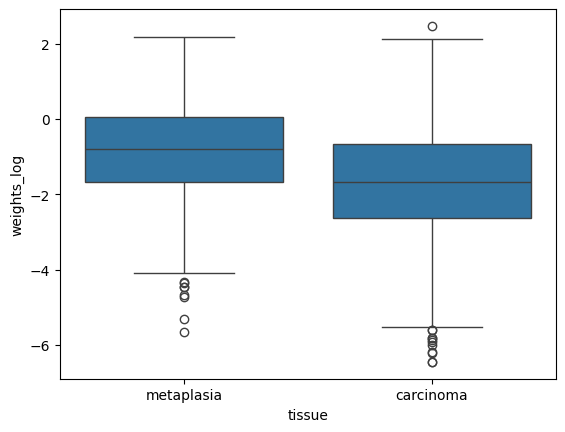

In [216]:
sns.boxplot(data=df, y="weights_log",x="tissue")
# plt.savefig('results/figs/fov_cap_endo_log_weights_boxplot.pdf')

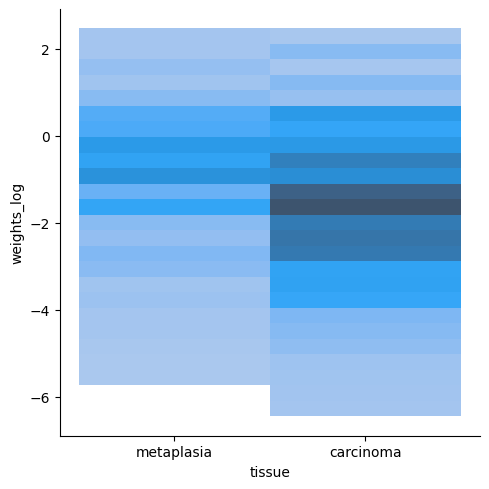

In [217]:
sns.displot(data=df, y="weights_log",x="tissue")

In [218]:
df[df.tissue == 'metaplasia']

,tissue,weights,weights_z,weights_log
0,metaplasia,0.481471,-0.086003,-0.730909
1,metaplasia,0.487966,-0.080334,-0.717510
2,metaplasia,0.865023,0.248787,-0.144999
3,metaplasia,0.486710,-0.081429,-0.720086
4,metaplasia,0.710179,0.113629,-0.342238
...,...,...,...,...
1055,metaplasia,0.372438,-0.181174,-0.987685
1056,metaplasia,0.381542,-0.173227,-0.963533
1057,metaplasia,0.371807,-0.181724,-0.989379
1058,metaplasia,0.076099,-0.439838,-2.575716


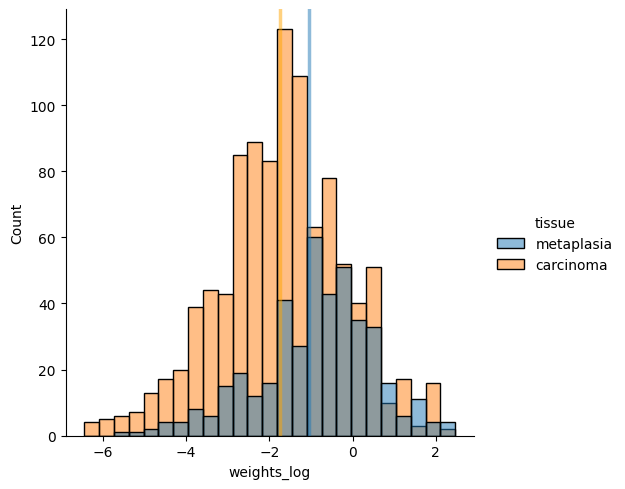

In [219]:
def specs(x,y, **kwargs):
    
    plt.axvline(x.mean(), c='k', ls='-', lw=2.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)

g = sns.displot(data=df, x="weights_log",hue="tissue")
plt.axvline(x=df[df.tissue == 'metaplasia'].weights_log.mean(), linewidth=3, color='#1f77b4', label="mean", alpha=0.9, ls='-', lw=2.5)
plt.axvline(x=df[df.tissue == 'metaplasia'].weights_log.median(), linewidth=3, color='#1f77b4', label="median", alpha=0.5, ls='-', lw=2.5)
plt.axvline(x=df[df.tissue == 'carcinoma'].weights_log.mean(), linewidth=3, color='orange', label="mean", alpha=0.9, ls='-', lw=2.5)
plt.axvline(x=df[df.tissue == 'carcinoma'].weights_log.median(), linewidth=3, color='orange', label="median", alpha=0.5, ls='-', lw=2.5)

#g.map(specs,'weights_log','tissue')
# plt.savefig('results/figs/fov_cap_endo_log_weights_displot.pdf')

In [220]:
from scipy.stats import ttest_ind


In [221]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, how="any", inplace=True)

In [222]:
df

,tissue,weights,weights_z,weights_log
0,metaplasia,0.481471,-0.086003,-0.730909
1,metaplasia,0.487966,-0.080334,-0.717510
2,metaplasia,0.865023,0.248787,-0.144999
3,metaplasia,0.486710,-0.081429,-0.720086
4,metaplasia,0.710179,0.113629,-0.342238
...,...,...,...,...
1591,carcinoma,0.008045,-0.499240,-4.822742
1592,carcinoma,0.046555,-0.465626,-3.067117
1594,carcinoma,0.013849,-0.494174,-4.279517
1595,carcinoma,0.095556,-0.422855,-2.348040


In [223]:
group1 = df[df['tissue']=='metaplasia']
group2 = df[df['tissue']=='carcinoma']
ttest_ind(group1['weights_log'], group2['weights_log'], equal_var=False)

TtestResult(statistic=9.629073679211825, pvalue=6.824205138083973e-21, df=843.6724892789653)

In [224]:
wm_df[cit, cjt][idx]

source   target 
JAG2     NOTCH1     0.481471
DLL1     NOTCH1     0.487966
JAG1     NOTCH1     0.865023
CNTN1    NOTCH1      0.48671
DLL4     NOTCH1     0.710179
                      ...   
SLC29A1  ADORA2A    0.042066
         ADORA2B    0.040113
         ADORA3     0.041318
SLC1A1   GRIK1      0.153776
         GRM2       0.152506
Name: (Foveolar cells, Capillary endothelial cells), Length: 260, dtype: Sparse[float64, 0]

In [225]:
wm_df[cjt, cit][idx]

source   target 
JAG2     NOTCH1      0.48139
DLL1     NOTCH1     0.461085
JAG1     NOTCH1     0.874129
CNTN1    NOTCH1            0
DLL4     NOTCH1     0.795427
                      ...   
SLC29A1  ADORA2A    0.372438
         ADORA2B    0.381542
         ADORA3     0.371807
SLC1A1   GRIK1      0.076099
         GRM2       0.079442
Name: (Capillary endothelial cells, Foveolar cells), Length: 260, dtype: Sparse[float64, 0]

/tmp/ipykernel_18220/2277559839.py:9: RuntimeWarning: divide by zero encountered in log
  ax=sns.scatterplot(x=range(0,len(np.log(vals))), y=np.log(vals))
/tmp/ipykernel_18220/2277559839.py:12: RuntimeWarning: divide by zero encountered in log
  plt.scatter(x=range(0,len(np.log(vals2))), y=np.log(vals2), color='r')


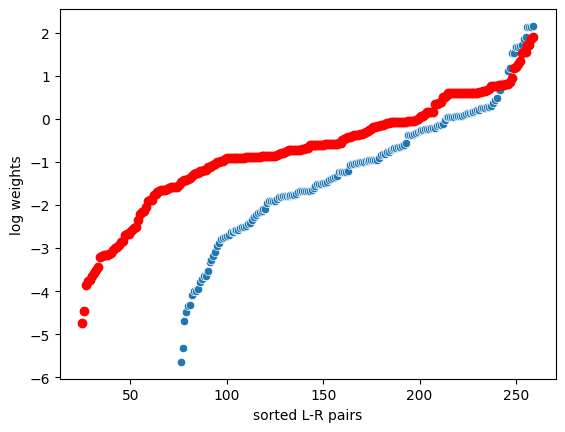

In [226]:
# j to i direction
vals = (wm_df[cjt, cit][idx]).to_list()
vals.sort()

# then the i to j direction 
vals2 = (wm_df[cit, cjt][idx]).to_list()
vals2.sort()

ax=sns.scatterplot(x=range(0,len(np.log(vals))), y=np.log(vals))
ax.set(ylabel='log weights', xlabel='sorted L-R pairs')

plt.scatter(x=range(0,len(np.log(vals2))), y=np.log(vals2), color='r')

# plt.savefig('results/figs/fov_cap_endo_log_weights_scatterplot.pdf')

In [227]:
pl_df1 = wm_df[cjt, cit][idx]
pl_df1[ [ ('HLA-E','VSIR'),('HLA-E','KLRK1'), ('HLA-E','KLRC1'), ('HLA-E','KLRC2') ] ]

source  target
HLA-E   VSIR      8.689407
        KLRK1     8.495751
        KLRC1     8.489613
        KLRC2     8.489365
Name: (Capillary endothelial cells, Foveolar cells), dtype: Sparse[float64, 0]

In [228]:
#pl_df1 = wm_df[cjt, cit][idx]
#pl_df1[ [ ('HLA-E','VSIR'),('HLA-E','KLRK1'), ('HLA-E','KLRC1'), ('HLA-E','KLRC2') ] ]

pl_df2 = wt_df[cjt, cit][jdx]
pl_df2[ [ ('HLA-E','VSIR'),('HLA-E','KLRK1'), ('HLA-E','KLRC1'), ('HLA-E','KLRC2') ] ]

source  target
HLA-E   VSIR      6.203305
        KLRK1     6.019438
        KLRC1     6.006501
        KLRC2     6.004107
Name: (Capillary endothelial cells, Foveolar cells), dtype: Sparse[float64, 0]

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'M.. HLA-E_VSIR'),
  Text(1, 0, 'M.. HLA-E_KLRK1'),
  Text(2, 0, 'M.. HLA-E_KLRC1'),
  Text(3, 0, 'M.. HLA-E_KLRC2'),
  Text(4, 0, 'T.. HLA-E_VSIR'),
  Text(5, 0, 'T.. HLA-E_KLRK1'),
  Text(6, 0, 'T.. HLA-E_KLRC1'),
  Text(7, 0, 'T.. HLA-E_KLRC2')])

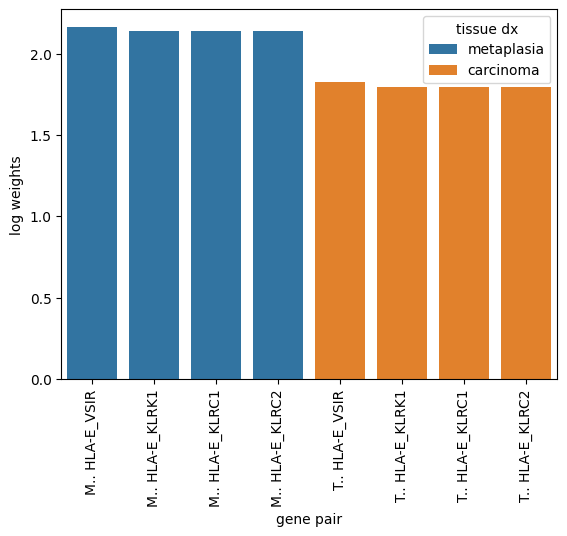

In [229]:
bardf = pd.DataFrame({'gene pair':['M.. HLA-E_VSIR','M.. HLA-E_KLRK1','M.. HLA-E_KLRC1','M.. HLA-E_KLRC2',
                       'T.. HLA-E_VSIR','T.. HLA-E_KLRK1','T.. HLA-E_KLRC1','T.. HLA-E_KLRC2'],
                      'log weights':[8.7,8.5,8.5,8.5,6.2,6.0,6.0,6.0],
                      'tissue dx': ['metaplasia','metaplasia','metaplasia','metaplasia','carcinoma','carcinoma','carcinoma','carcinoma']})

bardf['log weights'] = np.log(bardf[['log weights']])

ax = sns.barplot(data=bardf, x='gene pair', y='log weights', hue='tissue dx')
plt.xticks(rotation=90)

In [230]:
cellnames

['Arterial endothelial cells',
 'CD4 T cells',
 'CD8 T cells',
 'Capillary endothelial cells',
 'Chief cells',
 'Dendritic cells',
 'Dysplasia-carcinoma',
 'Fibroblasts, CAF',
 'Fibroblasts, NAF',
 'Foveolar cells',
 'Gastric mucous secreting cells',
 'Gastro-intestinal metaplasia',
 'Goblet cells',
 'Lymphatic endothelial cells',
 'Macrophages',
 'Mast cells',
 'Memory B cells',
 'Monocytes',
 'Myofibroblasts-1',
 'Myofibroblasts-2',
 'NK cells',
 'Naive B cells',
 'Neuroendocrine cells',
 'Neutrophils',
 'Pericytes',
 'Plasma cells',
 'Plasmacytoid dendritic cells',
 'Proliferating T cells',
 'Secretory cells',
 'Squamous epithelium basal',
 'Squamous epithelium intermediate',
 'Squamous epithelium upper',
 'Stressed Dying T cells',
 'T regs',
 'Venous endothelial cells']

In [231]:
# del ax, cit, cjt, df, fin, g, group1, group2, idx, idx2, jdx, jdx2, one_row, pl_df1, pl_df2, pm_df, pt_df, res_m, res_t, vals, vals2, wm_df, wt_df
del ax, cit, cjt, df, fin, g, group1, group2, idx, idx2, jdx, jdx2, one_row, pl_df1, pl_df2, res_m, res_t, vals, vals2 #, wm_df, wt_df

In [232]:
cit = 'Macrophages'
cjt = 'Neutrophils'

In [233]:
idx = np.array(pm_df[cit, cjt].tolist()) < 0.0001
jdx = np.array(pt_df[cit, cjt].tolist()) < 0.0001
idx2 = np.array(pm_df[cjt, cit].tolist()) < 0.0001
jdx2 = np.array(pt_df[cjt, cit].tolist()) < 0.0001

In [234]:
#take pairs that are either C_i -> C_j or C_j -> C_i
idx = [ (x or y) for (x,y) in zip(idx, idx2) ]
jdx = [ (x or y) for (x,y) in zip(jdx, jdx2) ]

In [238]:
import pandas as pd
df = pd.DataFrame({
    'tissue':(['metaplasia' for xi in np.where(idx)[0]]+['carcinoma' for xi in np.where(jdx)[0]]+
              ['metaplasia' for xi in np.where(idx)[0]]+['carcinoma' for xi in np.where(jdx)[0]]),
    'weights':(np.array(wm_df[cit, cjt])[idx].tolist()+np.array(wt_df[cit, cjt])[jdx].tolist()+
               np.array(wm_df[cjt, cit])[idx].tolist()+np.array(wt_df[cjt, cit])[jdx].tolist()),
})

In [239]:
df["weights_z"] = (df["weights"] - df["weights"].mean()) / df["weights"].std()

df["weights_log"] = np.log(df["weights"])

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [240]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, how="any", inplace=True)
df

,tissue,weights,weights_z,weights_log
0,metaplasia,2.363573,-0.091717,0.860175
1,metaplasia,1.792761,-0.111493,0.583757
2,metaplasia,1.237689,-0.130724,0.213246
3,metaplasia,9.308327,0.148889,2.230909
4,metaplasia,1.171684,-0.133011,0.158442
...,...,...,...,...
419,carcinoma,0.295103,-0.163381,-1.220430
420,carcinoma,0.163429,-0.167943,-1.811380
421,carcinoma,0.400381,-0.159734,-0.915338
422,carcinoma,0.050046,-0.171871,-2.994816


FileNotFoundError: [Errno 2] No such file or directory: 'results/figs/macs_neut_log_weights_boxplot.pdf'

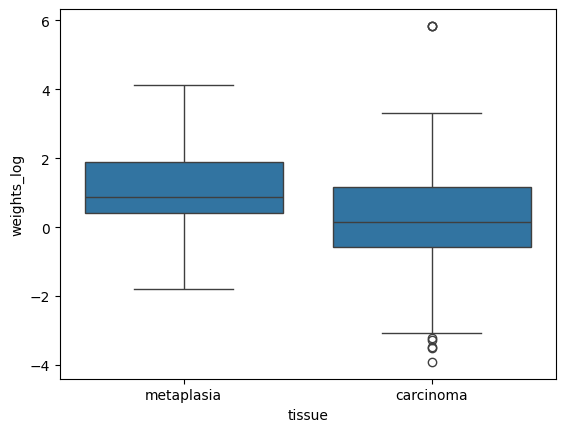

In [241]:
sns.boxplot(data=df, y="weights_log",x="tissue")
# plt.savefig('results/figs/macs_neut_log_weights_boxplot.pdf', bbox_inches="tight")

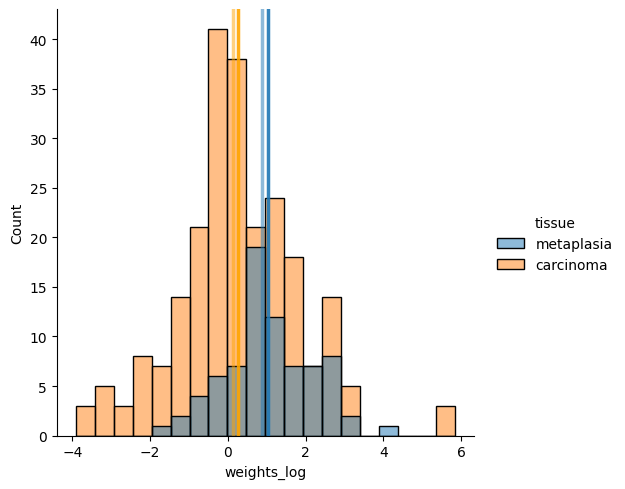

In [243]:
sns.displot(data=df, x="weights_log",hue="tissue")
plt.axvline(x=df[df.tissue == 'metaplasia'].weights_log.mean(), linewidth=3, color='#1f77b4', label="mean", alpha=0.9, ls='-', lw=2.5)
plt.axvline(x=df[df.tissue == 'metaplasia'].weights_log.median(), linewidth=3, color='#1f77b4', label="median", alpha=0.5, ls='-', lw=2.5)
plt.axvline(x=df[df.tissue == 'carcinoma'].weights_log.mean(), linewidth=3, color='orange', label="mean", alpha=0.9, ls='-', lw=2.5)
plt.axvline(x=df[df.tissue == 'carcinoma'].weights_log.median(), linewidth=3, color='orange', label="median", alpha=0.5, ls='-', lw=2.5)

# plt.savefig('results/figs/macs_neut_log_weights_displot.pdf', bbox_inches="tight")

In [244]:
group1 = df[df['tissue']=='metaplasia']
group2 = df[df['tissue']=='carcinoma']
ttest_ind(group1['weights_log'], group2['weights_log'], equal_var=False)

TtestResult(statistic=4.638867762310347, pvalue=6.818745407345722e-06, df=175.7975017728463)

In [245]:
wt_df[cjt, cit][jdx]

source   target
JAG2     NOTCH1           0
DLL1     NOTCH1           0
CNTN1    NOTCH1           0
DLL4     NOTCH1           0
DLL3     NOTCH1           0
                     ...   
SLC29A4  ADORA3    0.400381
SLC1A3   GRIK1     0.050046
         GRM6      0.092045
         GRIK4            0
         GRIK5            0
Name: (Neutrophils, Macrophages), Length: 156, dtype: Sparse[float64, 0]

In [246]:
wt_df[cit, cjt][jdx]

source   target
JAG2     NOTCH1     0.62711
DLL1     NOTCH1     0.66964
CNTN1    NOTCH1    0.622674
DLL4     NOTCH1    0.626864
DLL3     NOTCH1    0.629157
                     ...   
SLC29A4  ADORA3           0
SLC1A3   GRIK1     1.075012
         GRM6      1.042844
         GRIK4     1.026182
         GRIK5     1.020296
Name: (Macrophages, Neutrophils), Length: 156, dtype: Sparse[float64, 0]

/tmp/ipykernel_18220/2986038580.py:9: RuntimeWarning: divide by zero encountered in log
  ax=sns.scatterplot(x=range(0,156), y=np.log(vals))
/tmp/ipykernel_18220/2986038580.py:12: RuntimeWarning: divide by zero encountered in log
  plt.scatter(x=range(0,156), y=np.log(vals2), color='r')


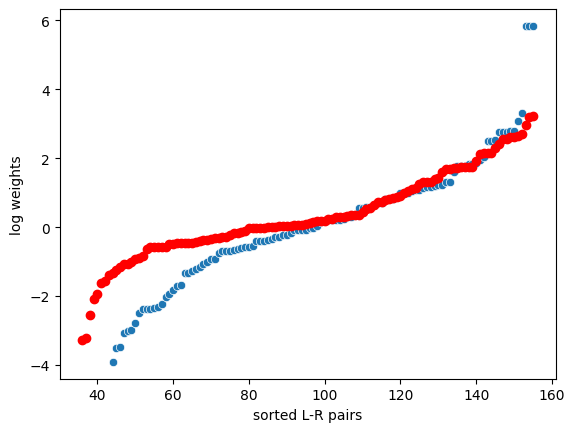

In [248]:
#sns.scatterplot(x=range(0,156), y=wt_df[cjt, cit][jdx])

vals = (wt_df[cjt, cit][jdx]).to_list()  # n to macs
vals.sort()

vals2 = (wt_df[cit, cjt][jdx]).to_list()
vals2.sort()

ax=sns.scatterplot(x=range(0,156), y=np.log(vals))
ax.set(ylabel='log weights', xlabel='sorted L-R pairs')

plt.scatter(x=range(0,156), y=np.log(vals2), color='r')
# plt.savefig('results/figs/macs_neut_log_weights_scatterplot.pdf')


In [249]:
pl_df1 = wm_df[cjt, cit][idx]
pl_df1[ [ ('CXCL8','CXCR2'), ('CXCL8','ACKR1'), ('CXCL8','CXCR1') ] ]

source  target
CXCL8   CXCR2     61.682986
        ACKR1             0
        CXCR1             0
Name: (Neutrophils, Macrophages), dtype: Sparse[float64, 0]

In [250]:
pl_df2 = wt_df[cjt, cit][jdx]
pl_df2[ [ ('CXCL8','CXCR2'), ('CXCL8','ACKR1'), ('CXCL8','CXCR1') ] ]

source  target
CXCL8   CXCR2     341.734541
        ACKR1     341.730005
        CXCR1     341.724067
Name: (Neutrophils, Macrophages), dtype: Sparse[float64, 0]

/opt/conda/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'M.. CXCL8_CXCR2'),
  Text(1, 0, 'M.. CXCL8_ACKR1'),
  Text(2, 0, 'M.. CXCL8_CXCR1'),
  Text(3, 0, 'T.. CXCL8_CXCR2'),
  Text(4, 0, 'T.. CXCL8_ACKR1'),
  Text(5, 0, 'T.. CXCL8_CXCR1')])

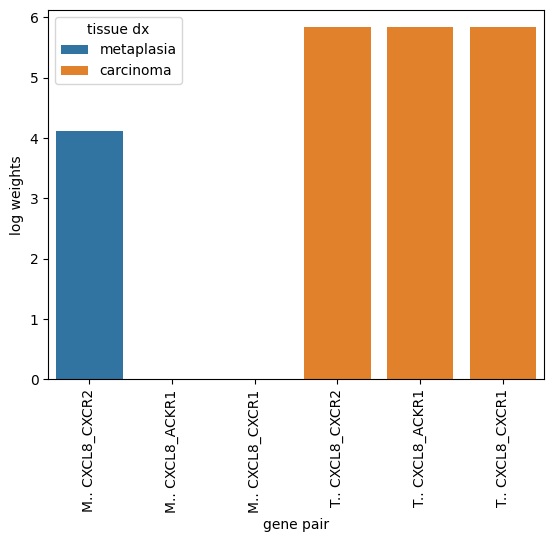

In [252]:
bardf = pd.DataFrame({'gene pair':['M.. CXCL8_CXCR2','M.. CXCL8_ACKR1','M.. CXCL8_CXCR1',
                                   'T.. CXCL8_CXCR2','T.. CXCL8_ACKR1','T.. CXCL8_CXCR1'],
                      'log weights':[61.7,0.0,0.0,341.7,341.7,341.7],
                      'tissue dx': ['metaplasia','metaplasia','metaplasia','carcinoma','carcinoma','carcinoma']})

bardf['log weights'] = np.log(bardf[['log weights']])

ax = sns.barplot(data=bardf, x='gene pair', y='log weights', hue='tissue dx')
plt.xticks(rotation=90)

# plt.savefig('results/figs/macs_neut_log_weights_barplot.pdf', bbox_inches="tight")

In [253]:
cit = 'Plasma cells'
cjt = 'Foveolar cells'

idx = np.array(pm_df[cit, cjt].tolist()) < 0.0001
jdx = np.array(pt_df[cit, cjt].tolist()) < 0.0001
idx2 = np.array(pm_df[cjt, cit].tolist()) < 0.0001
jdx2 = np.array(pt_df[cjt, cit].tolist()) < 0.0001

#take pairs that are either C_i -> C_j or C_j -> C_i
idx = [ (x or y) for (x,y) in zip(idx, idx2) ]
jdx = [ (x or y) for (x,y) in zip(jdx, jdx2) ]

df = pd.DataFrame({
    'tissue':(['metaplasia' for xi in np.where(idx)[0]]+['carcinoma' for xi in np.where(jdx)[0]]+
              ['metaplasia' for xi in np.where(idx)[0]]+['carcinoma' for xi in np.where(jdx)[0]]),
    'weights':(np.array(wm_df[cit, cjt])[idx].tolist()+np.array(wt_df[cit, cjt])[jdx].tolist()+
               np.array(wm_df[cjt, cit])[idx].tolist()+np.array(wt_df[cjt, cit])[jdx].tolist()),
})

df["weights_z"] = (df["weights"] - df["weights"].mean()) / df["weights"].std()
df["weights_log"] = np.log(df["weights"])

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, how="any", inplace=True)


/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


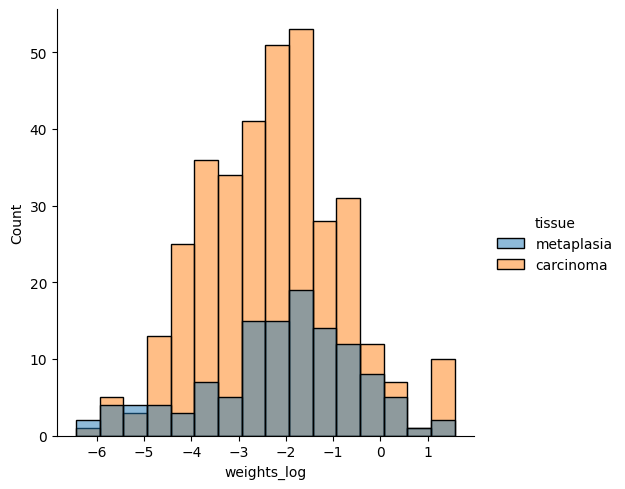

In [254]:
sns.displot(data=df, x="weights_log",hue="tissue")
# plt.savefig('results/figs/plasma_fov_log_weights_displot.pdf', bbox_inches="tight")

In [255]:
group1 = df[df['tissue']=='metaplasia']
group2 = df[df['tissue']=='carcinoma']
ttest_ind(group1['weights_log'], group2['weights_log'], equal_var=False)

TtestResult(statistic=1.104612312546609, pvalue=0.2707527318313082, df=186.23104790553535)

<Axes: xlabel='tissue', ylabel='weights_log'>

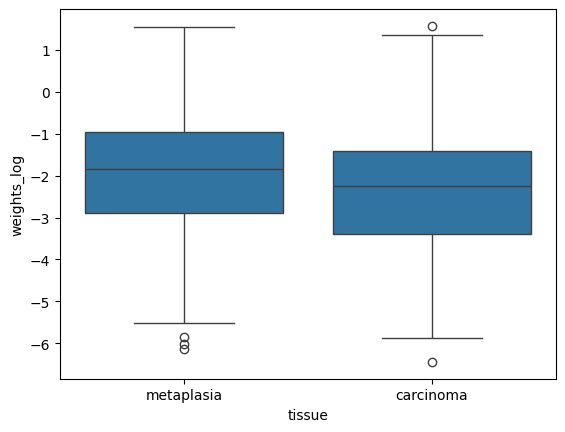

In [256]:
sns.boxplot(data=df, y="weights_log",x="tissue")
# plt.savefig('results/figs/plasma_fov_log_weights_boxplot.pdf', bbox_inches="tight")

In [257]:
wm_df[cjt, cit][idx]

source   target  
IGF1     ITGB4       0.067063
TNFSF14  LTBR        0.063917
         TNFRSF14    0.224346
LTA      TNFRSF14    0.212219
CD160    TNFRSF14    0.233238
                       ...   
TG       THRA        0.010514
SLC29A2  ADORA2A     0.104698
SLC1A1   GRIA4       0.131817
         GRIK1       0.141633
         GRM8        0.134208
Name: (Foveolar cells, Plasma cells), Length: 66, dtype: Sparse[float64, 0]

In [258]:
wm_df[cit, cjt][idx]

source   target  
IGF1     ITGB4       0.942959
TNFSF14  LTBR         0.66418
         TNFRSF14    0.784469
LTA      TNFRSF14    0.782538
CD160    TNFRSF14    0.790361
                       ...   
TG       THRA        0.177121
SLC29A2  ADORA2A     0.003979
SLC1A1   GRIA4        0.00954
         GRIK1       0.004979
         GRM8        0.005017
Name: (Plasma cells, Foveolar cells), Length: 66, dtype: Sparse[float64, 0]

/tmp/ipykernel_18220/462325831.py:9: RuntimeWarning: divide by zero encountered in log
  ax=sns.scatterplot(x=range(0,len(np.log(vals2))), y=np.log(vals2))
/tmp/ipykernel_18220/462325831.py:12: RuntimeWarning: divide by zero encountered in log
  plt.scatter(x=range(0,len(np.log(vals))), y=np.log(vals), color='r')


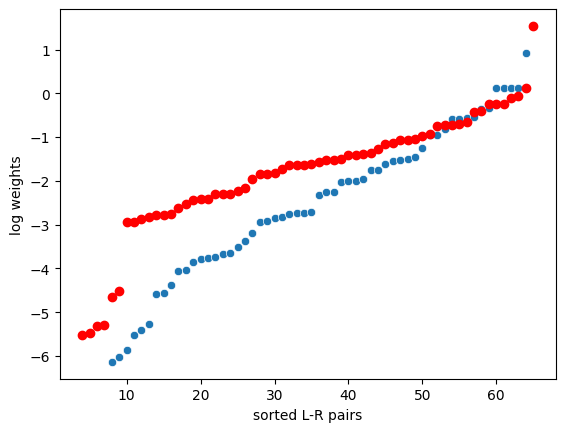

In [260]:
#sns.scatterplot(x=range(0,156), y=wt_df[cjt, cit][jdx])

vals = (wm_df[cit, cjt][idx]).to_list()  # plasma to fov
vals.sort()

vals2 = (wm_df[cjt, cit][idx]).to_list()
vals2.sort()

ax=sns.scatterplot(x=range(0,len(np.log(vals2))), y=np.log(vals2))
ax.set(ylabel='log weights', xlabel='sorted L-R pairs')

plt.scatter(x=range(0,len(np.log(vals))), y=np.log(vals), color='r')

# plt.savefig('results/figs/plasma_fov_log_weights_scatterplot.pdf')

In [261]:
np.log(vals)


/tmp/ipykernel_18220/2640076027.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(vals)


array([       -inf,        -inf,        -inf,        -inf, -5.52672368,
       -5.46510791, -5.30261631, -5.29499847, -4.65221974, -4.50890498,
       -2.94440649, -2.93808545, -2.87149571, -2.83471213, -2.77992575,
       -2.77407793, -2.74567716, -2.62702009, -2.51644081, -2.44260923,
       -2.41347943, -2.40992958, -2.30984305, -2.30866585, -2.30861216,
       -2.24125168, -2.15191659, -1.94604962, -1.84546048, -1.84491062,
       -1.82745716, -1.73092152, -1.64748768, -1.64688051, -1.64423671,
       -1.60449405, -1.562949  , -1.53303351, -1.51452402, -1.50115732,
       -1.41186848, -1.40016226, -1.38147104, -1.37011332, -1.27039436,
       -1.15203731, -1.12428734, -1.07221823, -1.07071501, -1.03324397,
       -0.96839803, -0.93266214, -0.75504733, -0.72297368, -0.72026201,
       -0.69835167, -0.66111017, -0.43381228, -0.40920234, -0.2452132 ,
       -0.2427484 , -0.23526526, -0.11734359, -0.05873295,  0.12430216,
        1.53508917])

In [262]:
pl_df1 = wm_df[cjt, cit][idx]
pl_df1[ [ ('CEACAM5','CEACAM1'),('CEACAM6','CEACAM1'),  ('VEGFA','FLT1') ] ] #('LGALS3','MERTK'),

source   target 
CEACAM5  CEACAM1    4.661475
CEACAM6  CEACAM1    2.503308
VEGFA    FLT1       1.132531
Name: (Foveolar cells, Plasma cells), dtype: Sparse[float64, 0]

In [263]:
pl_df2 = wt_df[cjt, cit][jdx]
pl_df2[ [ ('CEACAM5','CEACAM1'),('CEACAM6','CEACAM1'), ('LGALS3','MERTK'), ('VEGFA','FLT1') ] ]

source   target 
CEACAM5  CEACAM1      2.9479
CEACAM6  CEACAM1    1.315967
LGALS3   MERTK      3.894144
VEGFA    FLT1       3.706587
Name: (Foveolar cells, Plasma cells), dtype: Sparse[float64, 0]

/opt/conda/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'M.. CEACAM5_CEACAM1'),
  Text(1, 0, 'M.. CEACAM6_CEACAM1'),
  Text(2, 0, 'M.. LGALS3_MERTK'),
  Text(3, 0, 'M.. VEGFA_FLT1'),
  Text(4, 0, 'T.. CEACAM5_CEACAM1'),
  Text(5, 0, 'T.. CEACAM6_CEACAM1'),
  Text(6, 0, 'T.. LGALS3_MERTK'),
  Text(7, 0, 'T.. VEGFA_FLT1')])

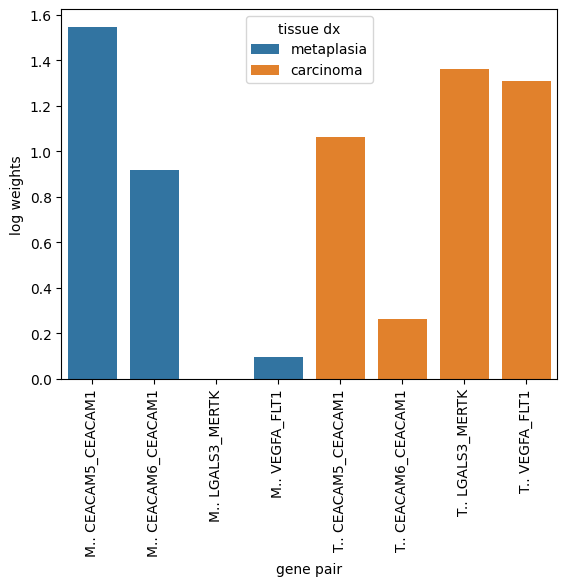

In [264]:
bardf = pd.DataFrame({'gene pair':['M.. CEACAM5_CEACAM1','M.. CEACAM6_CEACAM1','M.. LGALS3_MERTK','M.. VEGFA_FLT1',
                                   'T.. CEACAM5_CEACAM1','T.. CEACAM6_CEACAM1','T.. LGALS3_MERTK','T.. VEGFA_FLT1'],
                      'log weights':[4.7, 2.5, 0.0, 1.1, 2.9, 1.3, 3.9, 3.7],
                      'tissue dx': ['metaplasia','metaplasia','metaplasia','metaplasia','carcinoma','carcinoma','carcinoma','carcinoma']})

bardf['log weights'] = np.log(bardf[['log weights']])

ax = sns.barplot(data=bardf, x='gene pair', y='log weights', hue='tissue dx')
plt.xticks(rotation=90)

# plt.savefig('results/figs/plasma_fov_log_weights_barplot.pdf', bbox_inches="tight")